# REGRESSION

**Overview of the dataset**

This project is a regression problem aimed at predicting the growth rate of bacteria.   
The provided dataset includes results from experiments involving bacteria of various strains grown under different conditions, such as CO2 availability and light exposure.   
The growth curve of the bacteria is described by the target variables 'a', 'mu', 'tau', and 'a0'.  

Some of the information captured in this dataset include:  
- SucRatio : How good the bacteria is at producing sucrose  
- co2 : The amount of CO2 available  

The dataset includes only numerical variables.  


**The Task**

The task for this particular project is to perform Exploratory Analysis on the data and to build four Machine Learning pipelines for each of the target variables to predict using regression models. 
Each pipeline built is different to the other. It could be the features selected, the models used or in the last case, hyperparameter tuning has been used.

In [ ]:
import numpy as np # Library for performing numerical tasks
import pandas as pd # Library for dataset wrangling 
import matplotlib.pyplot as plt # Library for plotting
import seaborn as sns # Library for plotting

from sklearn.pipeline import Pipeline # To create separate pipelines for ease of execution

from sklearn.preprocessing import StandardScaler # For Scaling the data

# For Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 


# For Splitting the data into train/test or train/test/validation sets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import RFE # For Recursive Feature Elimination

# Performance Metrics for Model Evaluation
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Libraries specific for Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


# Libraries specific for Regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer

# Libraries specific for NLP
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans # Clustering
from sklearn.decomposition import LatentDirichletAllocation  # LDA
from sklearn.preprocessing import MaxAbsScaler 


import warnings
warnings.filterwarnings("ignore") 

### EDA

#### 1. Importing the dataset

In [17]:
reg_data = pd.read_csv('fitting-results.csv')
reg_data.head()

,n_cyanos,co2,light,SucRatio,Nsample,a,mu,tau,a0
0,262,73.578860,0.367894,0.451505,13123,5.033993,5.483011,0.552466,1.0
1,610,74.582194,0.481606,0.969900,12474,1.018406,1.830727,0.156458,1.0
2,118,33.111037,0.625418,0.909699,8867,2.569159,3.330662,0.412541,1.0
3,159,8.027676,0.575251,0.137124,16494,1.837341,3.371570,0.260798,1.0
4,957,38.796599,0.939799,0.234114,10267,0.999268,2.059303,0.098619,1.0


**Variable Description**


| variable | description |
|-----|------|
| n_cyanos | The number of Cyanobacteria available at the start |
| co2 | The amount of CO2 available |
| light | The amount of light available |
| SucRatio | How good the bacteria is at producing sucrose |
| Nsample | Experiment number |
| a | Maximum number of bacteria seen (Target variable) |
| mu | Growth rate of bacteria (Target variable) |
| tau | Time delay before bacteria starts growing (Target variable) |
| a0 | Initial level of bacteria (Target variable) |

#### 2. Checking the data types in the dataset

In [18]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19992 entries, 0 to 19991
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   n_cyanos  19992 non-null  int64  
 1   co2       19992 non-null  float64
 2   light     19992 non-null  float64
 3   SucRatio  19992 non-null  float64
 4   Nsample   19992 non-null  int64  
 5   a         19992 non-null  float64
 6   mu        19992 non-null  float64
 7   tau       19992 non-null  float64
 8   a0        19992 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.4 MB


- Here, we can see that all the features are numerical variables and also, the dataset has 19992 rows.

#### 3. Checking for Null Values

In [19]:
percent_missing = reg_data.isnull().sum() * 100 / len(reg_data)
percent_missing

n_cyanos    0.0
co2         0.0
light       0.0
SucRatio    0.0
Nsample     0.0
a           0.0
mu          0.0
tau         0.0
a0          0.0
dtype: float64

- We can confirm that the dataset has no null values

#### 4. Distribution of the Target Variables

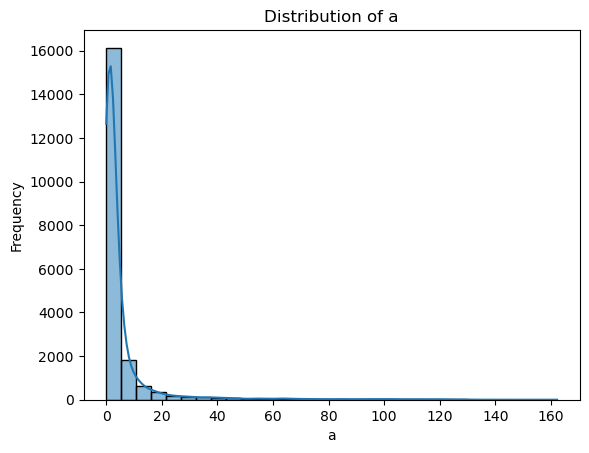

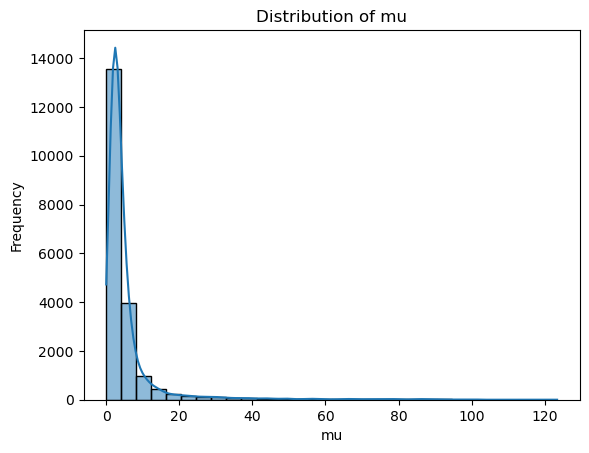

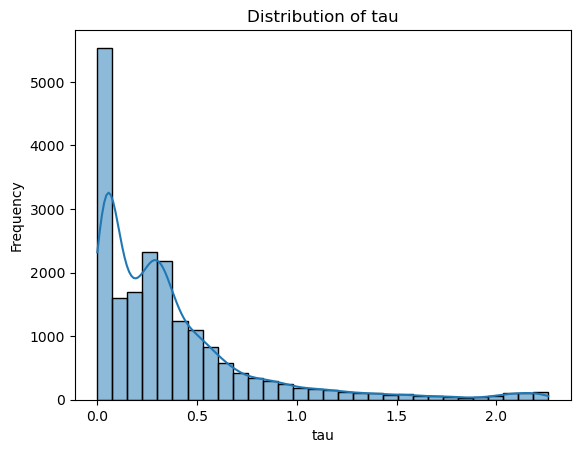

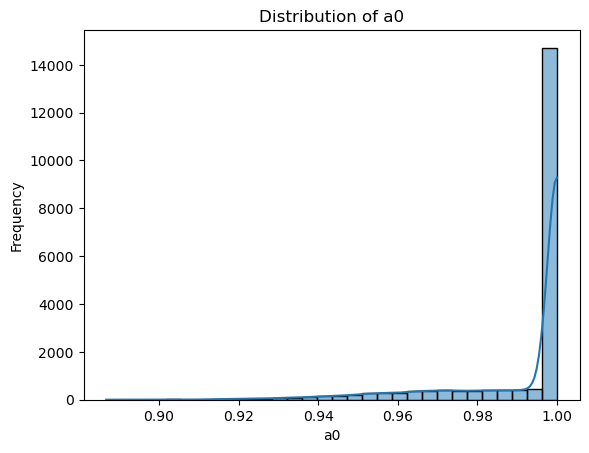

In [20]:
target_variables = ['a', 'mu', 'tau', 'a0']

for target in target_variables:
    sns.histplot(reg_data[target], kde=True, bins=30)
    plt.title(f"Distribution of {target}")
    plt.xlabel(target)
    plt.ylabel("Frequency")
    plt.show()

#### Inferences from Histogram

- It can be seen that the target variables **'a', 'mu', 'tau'** are extremely right skewed, except **'a0'** which is significantly left skewed in the opposite direction.
- Using the target variables as they are for the models will not yield good results.  
- Logarithmic Transformation will be used to normalize the target variables which will reduce the skewness before proceeding with model building.

#### 5. Distribution of the Predictor variables

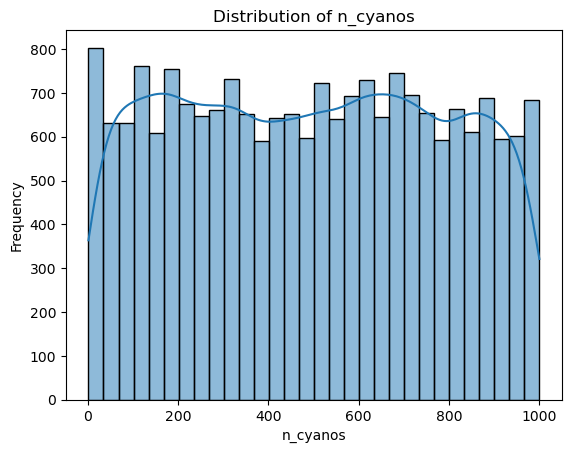

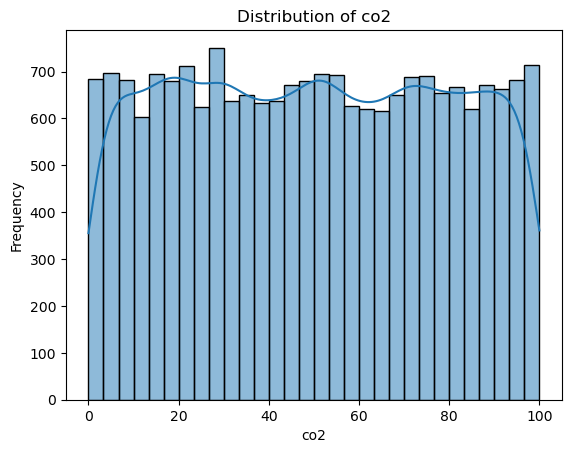

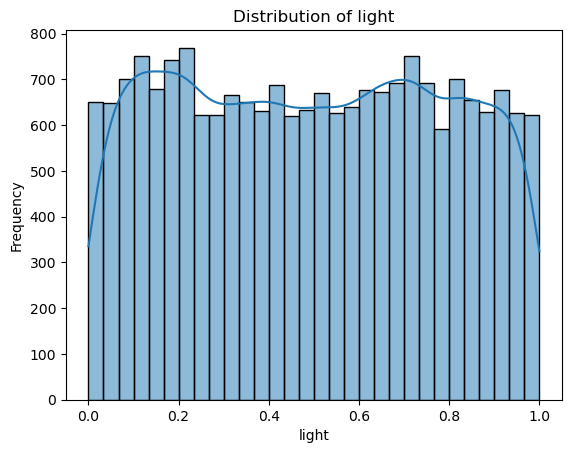

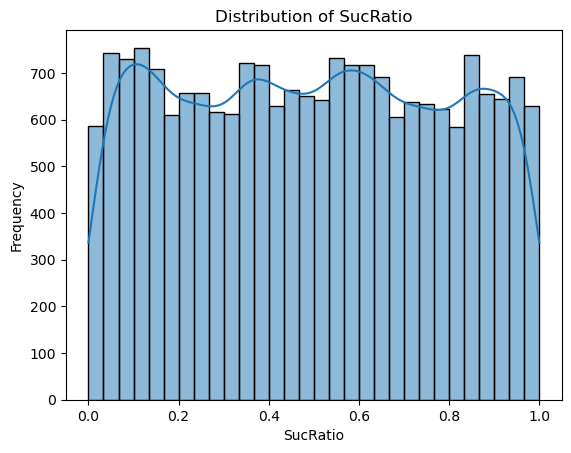

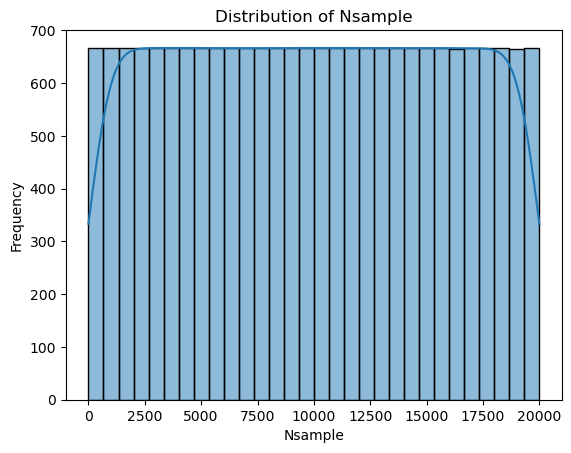

In [21]:
features = ['n_cyanos', 'co2', 'light', 'SucRatio', 'Nsample']

for x in features:
    sns.histplot(reg_data[x], kde=True, bins=30)
    plt.title(f"Distribution of {x}")
    plt.xlabel(x)
    plt.ylabel("Frequency")
    plt.show()

- The distribution of the predictor variables is not normal. This will affect the performance of the models.  
- To ensure better model performance, these variables will be standardized using z-score.

#### 6. Transformation of Target Variables and Normalisation of Predictor Variables

In [22]:
transformed_data = reg_data.copy()

transformed_data['a_transformed'] = np.log1p(transformed_data['a']) # Log Transform
transformed_data['mu_transformed'] = np.log1p(transformed_data['mu']) # Log Transform
transformed_data['tau_transformed'] = np.log1p(transformed_data['tau']) # Log Transform


features = ['n_cyanos', 'co2', 'light', 'SucRatio', 'Nsample']

for x in features:
    transformed_data[f'{x}_norm'] = (transformed_data[x]-transformed_data[x].mean())/transformed_data[x].std()



#### 7. Creating separate dataset for each target variable

In [23]:
a_data = transformed_data[['n_cyanos_norm', 'co2_norm', 'light_norm', 'SucRatio_norm', 'Nsample_norm', 'a_transformed']]
mu_data = transformed_data[['n_cyanos_norm', 'co2_norm', 'light_norm', 'SucRatio_norm', 'Nsample_norm', 'mu_transformed']]
tau_data = transformed_data[['n_cyanos_norm', 'co2_norm', 'light_norm', 'SucRatio_norm', 'Nsample_norm', 'tau_transformed']]

[Back-to-Regression](#REGRESSION) 

## Regression with Target Variable 'a' (Maximum Number of Bacteria Seen)

Performance Metrics Used:

- **MSE( Mean Squared Error)** : MSE measures the average squared difference between predicted and actual values. The closer it is to 0, the smaller the errors in prediction.  
- **R2** : Higher the R2, better the performance of the model. Usually, a score higher than 0.75 means the model is good at capturing the variance in the target variable. 

[PIPELINE 1](#PIPELINE-1---Linear-Regression-with-feature-selection-using-correlation---'a')  
[PIPELINE 2](#PIPELINE-2---Support-Vector-Regressor-'a')  
[PIPELINE 3](#PIPELINE-3-:-Random-Forest-Regressor---'a')  
[PIPELINE 4](#PIPELINE-4:-RANDOM-FOREST-WITH-HYPERPARAMETER-TUNING---'a')  
[RESULT](#RESULT---'a')   
[Back-to-Regression](#REGRESSION) 

### PIPELINE 1 - Linear Regression with feature selection using correlation - 'a'

#### Checking Feature Correlation with Target Variable

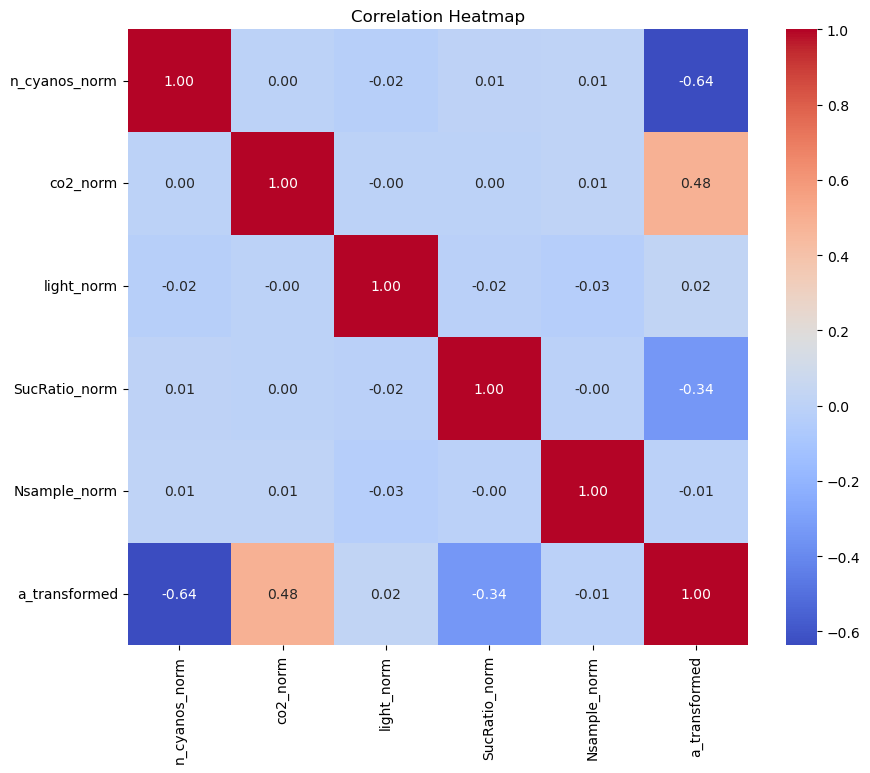

In [24]:
# Correlation matrix
corr_matrix = a_data.corr()

# Heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

##### Inference

From the heatmap, it can be seen that the correlation between the features and the target variable is not that high.  
- n_cyanos_norm (The number of Cyanobacteria available at the start), has the highest correlation at **-0.64**.  
- It is a negative correlation meaning **n_cyanos_norm** and **SucRatio_norm** are inversely proportional to **a_transformed**.
- **light_norm** and **Nsample_norm** have neglible correlation with **a_transformed**

#### Building Linear Regression model without light_norm and Nsample_norm

In [25]:
X = a_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a_data['a_transformed'] # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', LinearRegression())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)



# Results of model in dataframe
results_lr_a = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_lr_a = pd.DataFrame(results_lr_a)
result_pipeline_lr_a

,Metric,Validation,Test
0,MSE,0.217,0.183
1,R²,0.756,0.780


##### Observation

- The model has performed really well in the test set with MSE of **0.183**.  
- With R2 of **0.78**, the model captures 78% of variance in the target variable. This indicates the model is fitted well.
- Since Linear Regression is a base model, we can try other advance models like SVR or Random Forest Regressors to see if the results can be improved.

### PIPELINE 2 - Support Vector Regressor - 'a'

In [26]:
X = a_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a_data['a_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline with SVR
pipeline = Pipeline([
    ('regressor', SVR())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_svr_a = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_svr_a = pd.DataFrame(results_svr_a)
result_pipeline_svr_a


,Metric,Validation,Test
0,MSE,0.018,0.011
1,R²,0.980,0.986


##### Observation

- The model has performed extremely well in the test set with MSE of **0.011**.  
- With R2 of **0.986**, the model captures 99% of variance in the target variable. This indicates the model is fitted well.

### PIPELINE 3 : Random Forest Regressor - 'a'

In [27]:
X = a_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a_data['a_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_a = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_a = pd.DataFrame(results_rf_a)
result_pipeline_rf_a


,Metric,Validation,Test
0,MSE,0.007,0.003
1,R²,0.992,0.996


##### Observations

- Compared to SVR, Random Forest has performed even better in the test set with MSE of **0.003**.  
- With R2 of **0.996**, the model captures 99.6% of variance in the target variable. This indicates the model has a very strong fit.

### PIPELINE 4: RANDOM FOREST WITH HYPERPARAMETER TUNING - 'a'

In [28]:
# Define the features and target variable
X = a_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a_data['a_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Using Pipeline function to create a new pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Model after Hyperparameter Tuning
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Fitting the best model on the training data
best_model.fit(X_train, y_train)

# Predictions
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_hyp_a = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_hyp_a = pd.DataFrame(results_rf_hyp_a)
result_pipeline_rf_hyp_a


Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


,Metric,Validation,Test
0,MSE,0.007,0.003
1,R²,0.992,0.996


### RESULT - 'a'

#### Pipeline Comparison

In [29]:
results_pipeline = pd.DataFrame({'Pipeline 1: Linear Regression':result_pipeline_lr_a['Test'],
                               'Pipeline 2: SVR': result_pipeline_svr_a['Test'],
                               'Pipeline 3: Random Forest': result_pipeline_rf_a['Test'],
                               'Pipeline 4: Random Forest with Tuning' : result_pipeline_rf_hyp_a['Test']})
results_pipeline.index = ['MSE', 'R²']
results_pipeline

,Pipeline 1: Linear Regression,Pipeline 2: SVR,Pipeline 3: Random Forest,Pipeline 4: Random Forest with Tuning
MSE,0.183,0.011,0.003,0.003
R²,0.780,0.986,0.996,0.996


- Comparing the four pipelines, pipelines 3 and 4 have given us the same result (also best of the 4).  
- However, **execution time** for pipeline 4 which uses hyperparameter tuning, is very high in comparison with Pipeline 3.  
- Therefore, the best model for predicting 'a' - maximum number of bacteria seen is **Pipeline 3**.

[Back-to-'a'](#Regression-with-Target-Variable-'a'-(Maximum-Number-of-Bacteria-Seen)) 

[Back-to-Regression](#REGRESSION) 

## Regression with Target Variable 'mu' (Growth Rate of Bacteria)

[PIPELINE 1](#PIPELINE-1---Linear-Regression-with-feature-selection-using-correlation---'mu')  
[PIPELINE 2](#PIPELINE-2---Support-Vector-Regressor---'mu')  
[PIPELINE 3](#PIPELINE-3-:-Random-Forest-Regressor---'mu')  
[PIPELINE 4](#PIPELINE-4:-RANDOM-FOREST-WITH-HYPERPARAMETER-TUNING---'mu')  
[RESULT](#RESULT---'mu')   
[Back-to-Regression](#REGRESSION) 

### PIPELINE 1 - Linear Regression with feature selection using correlation - 'mu'

#### Checking Feature Correlation with Target Variable

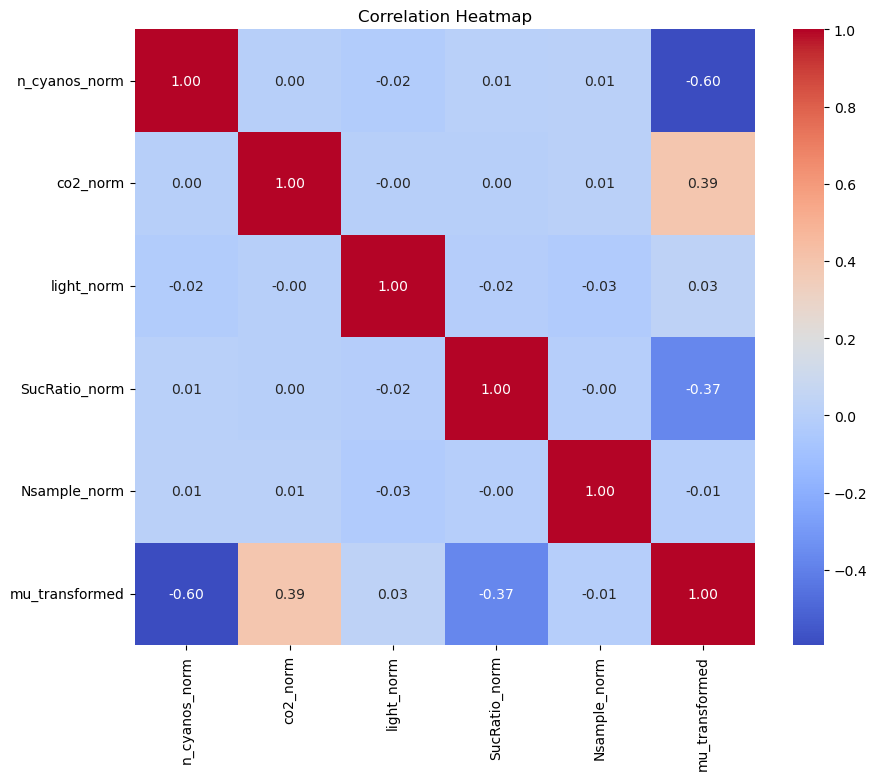

In [30]:
# Correlation matrix
corr_matrix = mu_data.corr()

# Heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

##### Inference

From the heatmap, it can be seen that the correlation between the features and the target variable is not that high.  
- n_cyanos_norm (The number of Cyanobacteria available at the start), has the highest correlation at **-0.60**.  
- It is a negative correlation meaning **n_cyanos_norm** and **SucRatio_norm** are inversely proportional to **mu_transformed**.
- **light_norm** and **Nsample_norm** have neglible correlation with **mu_transformed**

#### Building Linear Regression model without light_norm and Nsample_norm

In [31]:
X = mu_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = mu_data['mu_transformed'] # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', LinearRegression())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)



# Results of model in dataframe
results_lr_mu = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_lr_mu = pd.DataFrame(results_lr_mu)
result_pipeline_lr_mu

,Metric,Validation,Test
0,MSE,0.174,0.144
1,R²,0.651,0.682


[Back-to-'mu'](#Regression-with-Target-Variable-'mu'-(Growth-Rate-of-Bacteria)) 


### PIPELINE 2 - Support Vector Regressor - 'mu'

In [32]:
X = mu_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = mu_data['mu_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline with SVR
pipeline = Pipeline([
    ('regressor', SVR())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_svr_mu = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_svr_mu = pd.DataFrame(results_svr_mu)
result_pipeline_svr_mu


,Metric,Validation,Test
0,MSE,0.042,0.033
1,R²,0.916,0.928


[Back-to-'mu'](#Regression-with-Target-Variable-'mu'-(Growth-Rate-of-Bacteria)) 


### PIPELINE 3 : Random Forest Regressor - 'mu'

In [33]:
X = mu_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = mu_data['mu_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_mu = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_mu = pd.DataFrame(results_rf_mu)
result_pipeline_rf_mu


,Metric,Validation,Test
0,MSE,0.014,0.011
1,R²,0.972,0.976


[Back-to-'mu'](#Regression-with-Target-Variable-'mu'-(Growth-Rate-of-Bacteria)) 


### PIPELINE 4: RANDOM FOREST WITH HYPERPARAMETER TUNING - 'mu'

In [34]:
# Define the features and target variable
X = mu_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = mu_data['mu_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Using Pipeline function to create a new pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Model after Hyperparameter Tuning
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Fitting the best model on the training data
best_model.fit(X_train, y_train)

# Predictions
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_hyp_mu = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_hyp_mu = pd.DataFrame(results_rf_hyp_mu)
result_pipeline_rf_hyp_mu


Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


,Metric,Validation,Test
0,MSE,0.013,0.010
1,R²,0.973,0.977


### RESULT - 'mu'

#### Pipeline Comparison

In [35]:
results_pipeline = pd.DataFrame({'Pipeline 1: Linear Regression':result_pipeline_lr_mu['Test'],
                               'Pipeline 2: SVR': result_pipeline_svr_mu['Test'],
                               'Pipeline 3: Random Forest': result_pipeline_rf_mu['Test'],
                               'Pipeline 4: Random Forest with Tuning' : result_pipeline_rf_hyp_mu['Test']})
results_pipeline.index = ['MSE', 'R²']
results_pipeline

,Pipeline 1: Linear Regression,Pipeline 2: SVR,Pipeline 3: Random Forest,Pipeline 4: Random Forest with Tuning
MSE,0.144,0.033,0.011,0.010
R²,0.682,0.928,0.976,0.977


**Pipeline 1: Linear Regression** - An average performance with respect to R², but MSE is good.  
**Pipeline 2: SVR** - SVR is a huge improvement in comparison with Linear Regression, with an  R² explaining 93% variance in the target variable.  
**Pipeline 3 and Pipeline 4**:  
- On comparing the performances of the 4 pipelines, Pipelines 3 and 4 have provided very similar results.  
- Random Forest seems to be the best performing model with or without hyperparameter tuning.  
- The improvement in pipeline 4 compared to pipeline 3 is negligible and keeping computational cost as well in mind, **pipeline 3** is selected as the best performing pipeline.

[Back-to-'mu'](#Regression-with-Target-Variable-'mu'-(Growth-Rate-of-Bacteria)) 


[Back-to-Regression](#REGRESSION) 

## Regression with Target Variable 'tau' (Time Delay Before Bacteria Starts Growing)

[PIPELINE 1](#PIPELINE-1---Linear-Regression-with-feature-selection-using-correlation---'tau')  
[PIPELINE 2](#PIPELINE-2---Support-Vector-Regressor---'tau')  
[PIPELINE 3](#PIPELINE-3-:-Random-Forest-Regressor---'tau')  
[PIPELINE 4](#PIPELINE-4:-RANDOM-FOREST-WITH-HYPERPARAMETER-TUNING---'tau')  
[RESULT](#RESULT---'tau')   
[Back-to-Regression](#REGRESSION) 

### PIPELINE 1 - Linear Regression with feature selection using correlation - 'tau'

#### Checking Feature Correlation with Target Variable

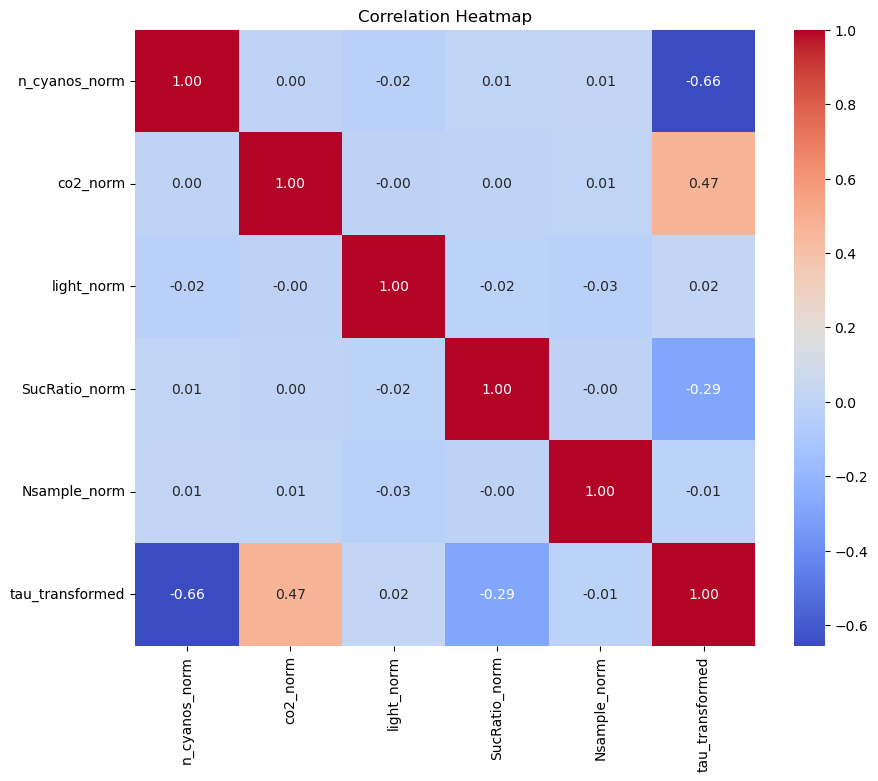

In [36]:
# Correlation matrix
corr_matrix = tau_data.corr()

# Heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

##### Inference

From the heatmap, it can be seen that the correlation between the features and the target variable is not that high.  
- n_cyanos_norm (The number of Cyanobacteria available at the start), has the highest correlation at **-0.66**.  
- It is a negative correlation meaning **n_cyanos_norm** and **SucRatio_norm** are inversely proportional to **tau_transformed**.
- **light_norm** and **Nsample_norm** have neglible correlation with **tau_transformed**

#### Building Linear Regression model without light_norm and Nsample_norm

In [37]:
X = tau_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = tau_data['tau_transformed'] # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', LinearRegression())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)



# Results of model in dataframe
results_lr_tau = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_lr_tau = pd.DataFrame(results_lr_tau)
result_pipeline_lr_tau

,Metric,Validation,Test
0,MSE,0.017,0.015
1,R²,0.738,0.756


[back-to-'tau'](#Regression-with-Target-Variable-'tau'-(Time-Delay-Before-Bacteria-Starts-Growing)) 

### PIPELINE 2 - Support Vector Regressor - 'tau'

In [38]:
X = tau_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = tau_data['tau_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline with SVR
pipeline = Pipeline([
    ('regressor', SVR())  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_svr_tau = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_svr_tau = pd.DataFrame(results_svr_tau)
result_pipeline_svr_tau


,Metric,Validation,Test
0,MSE,0.003,0.003
1,R²,0.949,0.954


[back-to-'tau'](#Regression-with-Target-Variable-'tau'-(Time-Delay-Before-Bacteria-Starts-Growing)) 

### PIPELINE 3 : Random Forest Regressor - 'tau'

In [39]:
X = tau_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = tau_data['tau_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_tau = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_tau = pd.DataFrame(results_rf_tau)
result_pipeline_rf_tau


,Metric,Validation,Test
0,MSE,0.001,0.000
1,R²,0.990,0.993


[back-to-'tau'](#Regression-with-Target-Variable-'tau'-(Time-Delay-Before-Bacteria-Starts-Growing)) 

### PIPELINE 4: RANDOM FOREST WITH HYPERPARAMETER TUNING - 'tau'

In [40]:
# Define the features and target variable
X = tau_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = tau_data['tau_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# Using Pipeline function to create a new pipeline with RandomForestRegressor
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best Model after Hyperparameter Tuning
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Fitting the best model on the training data
best_model.fit(X_train, y_train)

# Predictions
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_hyp_tau = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_hyp_tau = pd.DataFrame(results_rf_hyp_tau)
result_pipeline_rf_hyp_tau


Best Hyperparameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


,Metric,Validation,Test
0,MSE,0.001,0.000
1,R²,0.990,0.993


### RESULT - 'tau'

#### Pipeline Comparison

In [41]:
results_pipeline = pd.DataFrame({'Pipeline 1: Linear Regression':result_pipeline_lr_tau['Test'],
                               'Pipeline 2: SVR': result_pipeline_svr_tau['Test'],
                               'Pipeline 3: Random Forest': result_pipeline_rf_tau['Test'],
                               'Pipeline 4: Random Forest with Tuning' : result_pipeline_rf_hyp_tau['Test']})
results_pipeline.index = ['MSE', 'R²']
results_pipeline

,Pipeline 1: Linear Regression,Pipeline 2: SVR,Pipeline 3: Random Forest,Pipeline 4: Random Forest with Tuning
MSE,0.015,0.003,0.000,0.000
R²,0.756,0.954,0.993,0.993


**Pipeline 1: Linear Regression** - An good performance with respect to R², and MSE is very good.  
**Pipeline 2: SVR** - SVR is a huge improvement in comparison with Linear Regression, with an  R² explaining 95% variance in the target variable.  
**Pipeline 3 and Pipeline 4**:  
- On comparing the performances of the 4 pipelines, Pipelines 3 and 4 have provided the same and excellent results. 
- MSE is 0 meaning the model is exact in prediction. This could mean that the model is overfitting. 
- But since we ensured that the test set is not used for training or hyperparameter tuning, the model cannot be overfitting.
- Random Forest seems to be the best performing model with or without hyperparameter tuning.  
- The improvement in pipeline 4 compared to pipeline 3 is negligible and keeping computational cost as well in mind, **pipeline 3** is selected as the best performing pipeline.

[back-to-'tau'](#Regression-with-Target-Variable-'tau'-(Time-Delay-Before-Bacteria-Starts-Growing)) 

[Back-to-Regression](#REGRESSION) 

## Regression with Target Variable 'a0' (Initial Level of Bacteria)

[PIPELINE-1](#PIPELINE-1---Random-Forest-Regressor-with-Log-Transform-on-a0)  
[PIPELINE-2](#PIPELINE-2---Random-Forest-Regressor-with-Reciprocal-Transformation-on-a0)  
[PIPELINE-3](#PIPELINE-3---Random-Forest-Regressor-with-Zscore-on-a0)  
[PIPELINE-4](#PIPELINE-4---Random-Forest-Regressor-with-no-Transformation-on-a0)  
[RESULT](#RESULT---'a0')  
[Back-to-Regression](#REGRESSION)  

### PIPELINE 1 - Random Forest Regressor with Log Transform on a0

In [42]:
a0_data = transformed_data[['n_cyanos_norm', 'co2_norm', 'light_norm', 'SucRatio_norm', 'Nsample_norm', 'a0']]

In [43]:
a0_data['a0_log_transformed'] = np.log1p(a0_data['a0']) # Log Transform

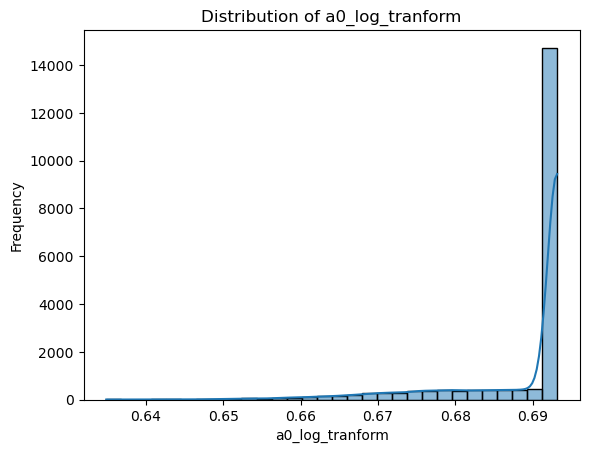

In [44]:
sns.histplot(a0_data['a0_log_transformed'], kde=True, bins=30)
plt.title(f"Distribution of a0_log_tranform")
plt.xlabel('a0_log_tranform')
plt.ylabel("Frequency")
plt.show()

In [45]:
X = a0_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a0_data['a0_log_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_a0 = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_log = pd.DataFrame(results_rf_a0)
result_pipeline_rf_log


,Metric,Validation,Test
0,MSE,0.00,0.000
1,R²,0.71,0.696


[back-to-a0](#Regression-with-Target-Variable-'a0'-(Initial-Level-of-Bacteria))

### PIPELINE 2 - Random Forest Regressor with Reciprocal Transformation on a0

In [46]:
a0_data['a0_reciprocal_transformed'] = 1 / (a0_data['a0'] + 1e-8)

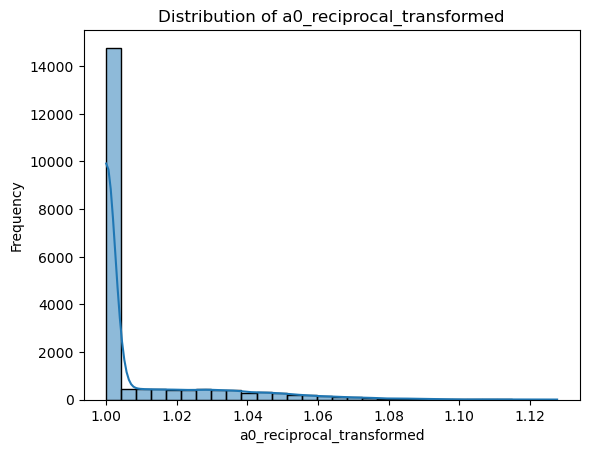

In [47]:
sns.histplot(a0_data['a0_reciprocal_transformed'], kde=True, bins=30)
plt.title(f"Distribution of a0_reciprocal_transformed")
plt.xlabel('a0_reciprocal_transformed')
plt.ylabel("Frequency")
plt.show()

In [48]:
X = a0_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a0_data['a0_reciprocal_transformed']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_a0 = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_rec = pd.DataFrame(results_rf_a0)
result_pipeline_rf_rec


,Metric,Validation,Test
0,MSE,0.000,0.000
1,R²,0.699,0.686


[back-to-a0](#Regression-with-Target-Variable-'a0'-(Initial-Level-of-Bacteria))

### PIPELINE 3 - Random Forest Regressor with Zscore on a0

In [49]:
a0_data['a0_zscore'] = (a0_data['a0']-a0_data['a0'].mean())/a0_data['a0'].std()

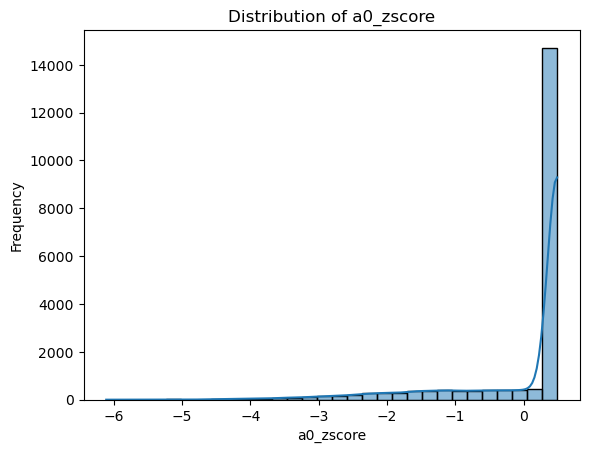

In [50]:
sns.histplot(a0_data['a0_zscore'], kde=True, bins=30)
plt.title(f"Distribution of a0_zscore")
plt.xlabel('a0_zscore')
plt.ylabel("Frequency")
plt.show()

In [51]:
X = a0_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a0_data['a0_zscore']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_a0 = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf_zscore = pd.DataFrame(results_rf_a0)
result_pipeline_rf_zscore


,Metric,Validation,Test
0,MSE,0.294,0.368
1,R²,0.714,0.701


[back-to-a0](#Regression-with-Target-Variable-'a0'-(Initial-Level-of-Bacteria))

### PIPELINE 4 - Random Forest Regressor with no Transformation on a0

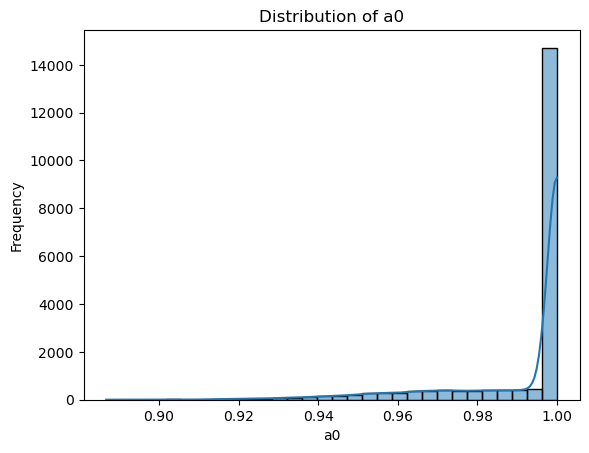

In [52]:
sns.histplot(a0_data['a0'], kde=True, bins=30)
plt.title(f"Distribution of a0")
plt.xlabel('a0')
plt.ylabel("Frequency")
plt.show()

In [53]:
X = a0_data[['n_cyanos_norm', 'co2_norm', 'SucRatio_norm']]  # Variables used for prediction
y_a = a0_data['a0']  # Target variable

# Splitting into Train, Test, and Validation Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_a, test_size=0.2, random_state=26)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=26)

# Using Pipeline function to create a new pipeline
pipeline = Pipeline([
    ('regressor', RandomForestRegressor(random_state=26))  # Model
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predictions
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

# Performance Metrics for Validation
val_mse = mean_squared_error(y_val, y_pred_val)
val_r2 = r2_score(y_val, y_pred_val)

# Performance Metrics for Test
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

# Results of model in dataframe
results_rf_a0 = {
    "Metric": ["MSE", "R²"],
    "Validation": [round(val_mse, 3), round(val_r2, 3)],
    "Test": [round(test_mse, 3), round(test_r2, 3)]
}

result_pipeline_rf = pd.DataFrame(results_rf_a0)
result_pipeline_rf


,Metric,Validation,Test
0,MSE,0.000,0.000
1,R²,0.714,0.702


### RESULT - 'a0'

#### Pipeline Comparison

In [54]:
results_pipeline = pd.DataFrame({'Pipeline 1: RF with Log Transform':result_pipeline_rf_log['Test'],
                               'Pipeline 2: RF with Reciprocal Transform': result_pipeline_rf_rec['Test'],
                               'Pipeline 3: RF with Zscore': result_pipeline_rf_zscore['Test'],
                               'Pipeline 4: RF with no Transform' : result_pipeline_rf['Test']})
results_pipeline.index = ['MSE', 'R²']
results_pipeline

,Pipeline 1: RF with Log Transform,Pipeline 2: RF with Reciprocal Transform,Pipeline 3: RF with Zscore,Pipeline 4: RF with no Transform
MSE,0.000,0.000,0.368,0.000
R²,0.696,0.686,0.701,0.702


**Pipeline 1: RF with Log Transformation** and **Pipeline 2: RF with Reciprocal Transformation**:    
    - The models have performed very similarly with MSE 0 and R² at almost 70%.  
    - It also shows that both the transformation techniques have worked well.  
        
**Pipeline 3: RF with Zscore**:  
    - This pipeline has a slightly better R², but the MSE has increased a lot compared to pipelines 1 and 2.   
    - This could be because we have applied normalization.
    
**Pipeline 4: RF with No Transformation** -   
    - This pipeline has provided the best result on comparison with the other 3 pipelines.    
    - The MSE is 0 and the R² is at 70%.  
    
Since pipeline 4 does not require any transformation, it simplifies the process. Therefore, for the target variable **'a0'**, pipeline 4 is the best option.